In [1]:
#Import Libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)


import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import seaborn as sns
import os
import tarfile
from wordcloud import WordCloud

In [2]:
%%bash
wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2024-09-27 01:26:45--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  897K 92s
    50K .......... .......... .......... .......... ..........  0% 2.46M 62s
   100K .......... .......... .......... .......... ..........  0% 1.29M 62s
   150K .......... .......... .......... .......... ..........  0% 2.56M 54s
   200K .......... .......... .......... .......... ..........  0% 2.52M 50s
   250K .......... .......... .......... .......... ..........  0% 2.65M 46s
   300K .......... .......... .......... .......... ..........  0% 2.74M 44s
   350K .......... .......... .......... .......... ..........  0% 24.7M 39s
   400K .......... .......... ....

In [4]:
ls

aclImdb_v1.tar.gz  sample_data/


In [5]:
with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
    tar.extractall()

In [60]:
def load_reviews(directory, encoding='utf-8'):
    reviews = []
    for filename in os.listdir(f"aclImdb/{directory}"):
        with open(f"aclImdb/{directory}/{filename}", "r", encoding=encoding) as f:
            review = f.read().strip()
            reviews.append(review)
    return reviews

In [61]:
train_pos_reviews = load_reviews("train/pos")
train_neg_reviews = load_reviews("train/neg")
test_pos_reviews = load_reviews("test/pos")
test_neg_reviews = load_reviews("test/neg")

In [63]:
# Create DataFrames
train_pos_df = pd.DataFrame({'review': train_pos_reviews, 'sentiment': 'positive'})
train_neg_df = pd.DataFrame({'review': train_neg_reviews, 'sentiment': 'negative'})
test_pos_df = pd.DataFrame({'review': test_pos_reviews, 'sentiment': 'positive'})
test_neg_df = pd.DataFrame({'review': test_neg_reviews, 'sentiment': 'negative'})
train_neg_df.shape
train_pos_df.head()

,review,sentiment
0,The tweedy professor-types thought they had it...,positive
1,Buddy is an entertaining family film set in a ...,positive
2,Hi everyone my names Larissa I'm 13 years old ...,positive
3,"""It wasn't me! It was, er, my twin brother Rup...",positive
4,This film is stunningly beautiful. Goldsworthy...,positive


In [64]:
# Combine DataFrames
all_reviews_df = pd.concat([train_pos_df, train_neg_df, test_pos_df, test_neg_df])

#Print the first few rows of the combined DataFrame
print(all_reviews_df.head())

                                              review sentiment
0  The tweedy professor-types thought they had it...  positive
1  Buddy is an entertaining family film set in a ...  positive
2  Hi everyone my names Larissa I'm 13 years old ...  positive
3  "It wasn't me! It was, er, my twin brother Rup...  positive
4  This film is stunningly beautiful. Goldsworthy...  positive


In [65]:
df= all_reviews_df

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [67]:
df.shape

(50000, 2)

In [68]:
df.isnull().sum()

,0
review,0
sentiment,0


In [69]:
df.duplicated().sum()

418

In [70]:
df.drop_duplicates(inplace=True)

In [71]:
lab =LabelEncoder()
df["sentiment"] = lab.fit_transform(df["sentiment"])
df.head()

,review,sentiment
0,The tweedy professor-types thought they had it...,1
1,Buddy is an entertaining family film set in a ...,1
2,Hi everyone my names Larissa I'm 13 years old ...,1
3,"""It wasn't me! It was, er, my twin brother Rup...",1
4,This film is stunningly beautiful. Goldsworthy...,1


In [72]:
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Stem the words
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    # Join the tokens back into a string
    cleaned_text = ' '.join(stemmed_tokens)

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:
df['cleaned_review'] = df['review'].apply(clean_text)

In [20]:
#Flatten the list of lists:
all_words = [word for sublist in df['cleaned_review'] for word in sublist]

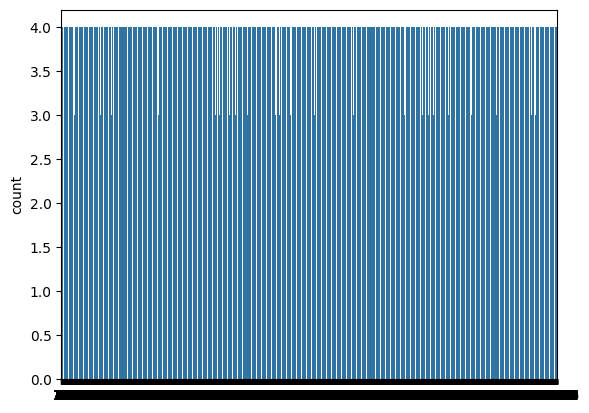

In [21]:
sns.countplot(df["sentiment"]);

In [22]:
df["review_len"] = df["review"].astype(str).apply(len)
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

In [23]:
df.drop(columns="review", inplace=True)
df.head()

,sentiment,cleaned_review,review_len,word_count
0,1,tweedi professortyp thought figur today peopl ...,1875,313
1,1,buddi entertain famili film set time human ani...,722,125
2,1,hi everyon name larissa im year old year old w...,1659,363
3,1,wasnt er twin brother rupert bobbi say dugan c...,596,107
4,1,film stunningli beauti goldsworthi art realli ...,402,71


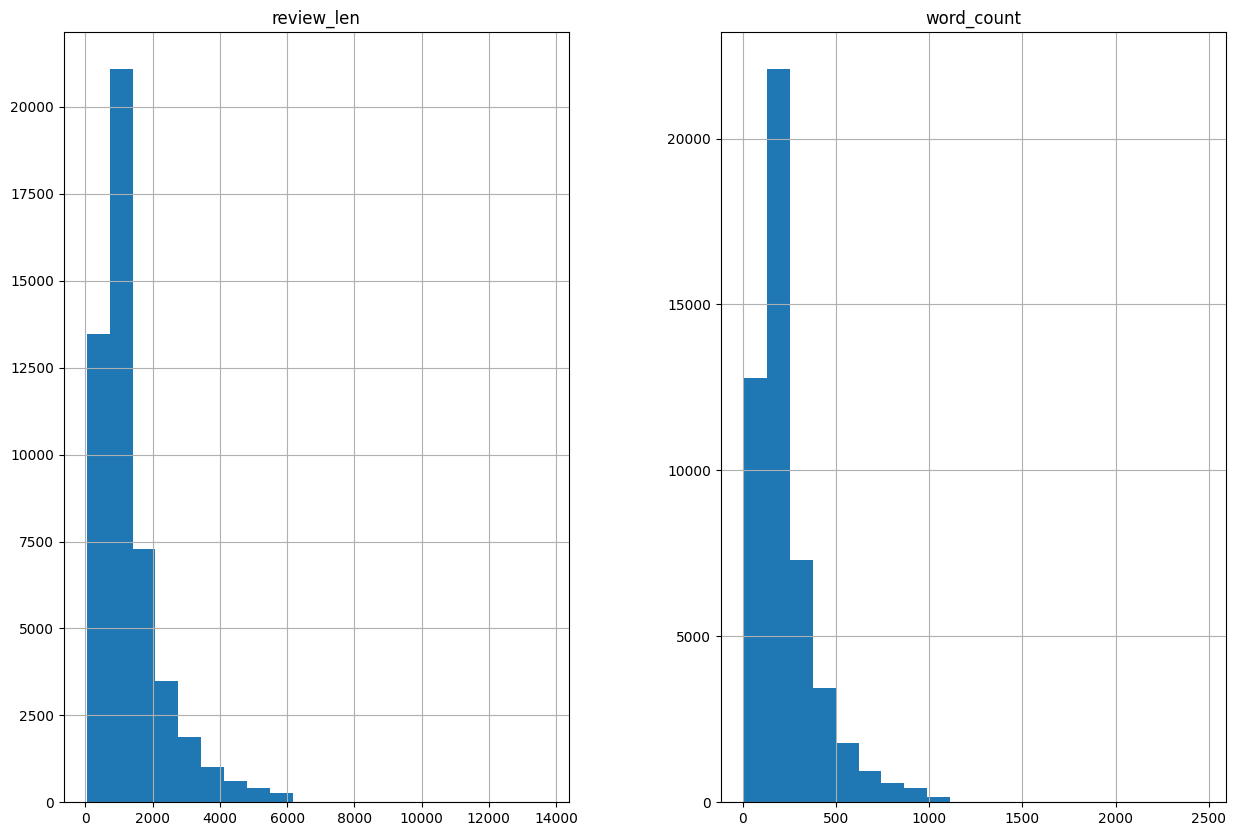

In [24]:
df[["review_len", "word_count"]].hist(bins=20, figsize=(15, 10));

In [83]:
x= df["review"]
y= df["sentiment"]

In [84]:
y.shape

(49582,)

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf= TfidfVectorizer(max_features= 5000)
X =tf.fit_transform(x).toarray()

# Get the vocabulary
vb = tf.get_feature_names_out()

# Print the TF-IDF values for the first review
print(X[0])

[0. 0. 0. ... 0. 0. 0.]


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39665, 5000), (9917, 5000), (39665,), (9917,))

In [88]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [89]:
# test model using test data
pred =mnb.predict(X_test)

In [90]:
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

0.8530805687203792
[[4169  741]
 [ 716 4291]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4910
           1       0.85      0.86      0.85      5007

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



In [91]:
pd.DataFrame(np.c_[y_test, pred], columns=["Actual", "Predicted"])

,Actual,Predicted
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
9912,1,1
9913,0,0
9914,0,0
9915,0,1


In [92]:
pickle.dump(tf, open("Count-Vectorizer.pkl", "wb"))
pickle.dump(mnb, open("Movies_Review_Classification.pkl", "wb"))

In [93]:
save_tf =pickle.load(open("Count-Vectorizer.pkl", "rb"))
model =pickle.load(open("Movies_Review_Classification.pkl", "rb"))

In [94]:
def test_model(sentence):
    sen = save_tf.transform([sentence]).toarray()
    res = model.predict(sen)[0]
    if res == 1:
        return "Positive Review"
    else:
        return "Negative Review"

In [107]:
sen = "after watching the movie, i realized it's not a nice movie for children, even some adults might not like it. i can rate it 7/10 anyways"
res =test_model(sen)

In [108]:
res

'Negative Review'